In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pyproj
from shapely import geometry
import matplotlib.pyplot as plt


%matplotlib inline

# Abrindo os arquivos pré-recortados

In [11]:
gama_raw = pd.read_csv('../database/csv/gama_area_norte.csv')

In [12]:
gama_raw.shape

(59372, 13)

In [13]:
gama_raw['geometry'] = [geometry.Point(x, y) for x, y in zip(gama_raw['X'], gama_raw['Y'])]

In [14]:
crs = "+proj=utm +zone=23 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
gama_raw = gpd.GeoDataFrame(gama_raw, geometry='geometry', crs=crs)
gama_raw.head()

Unnamed: 0  KPERC    eU    eTH  UTHRAZAO          X           Y     MDT  \
0           0   1.02  1.11  13.00       0.1  292878.15  7624109.00  600.12   
1           1   1.47  1.09  13.53       0.1  292876.59  7624190.38  599.47   
2           2   1.82  1.15  14.97       0.1  292875.03  7624271.94  600.63   
3           3   1.52  1.22  14.94       0.1  292874.16  7624353.33  602.72   
4           4   1.34  1.15  13.11       0.1  292873.81  7624434.72  602.21   

   THKRAZAO  CTCOR   LATITUDE  LONGITUDE                        geometry  
0      9.86   23.0 -21.473638 -46.998997  POINT (292878.150 7624109.000)  
1      9.77   24.2 -21.472903 -46.999002  POINT (292876.590 7624190.380)  
2      9.81   25.3 -21.472167 -46.999007  POINT (292875.030 7624271.940)  
3      9.96   25.5 -21.471432 -46.999005  POINT (292874.160 7624353.330)  
4     10.18   24.5 -21.470697 -46.998998  POINT (292873.810 7624434.720)

In [16]:
mag_raw = pd.read_csv('../database/csv/mag_area_norte.csv')

In [17]:
mag_raw['geometry'] = [geometry.Point(x, y) for x, y in zip(mag_raw['X'], mag_raw['Y'])]

In [23]:
crs = "+proj=utm +zone=23 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
mag_raw = gpd.GeoDataFrame(mag_raw, geometry='geometry', crs=crs)
mag_raw.head()

Unnamed: 0  Unnamed: 0.1          X           Y     MDT   LATITUDE  \
0           0             0  292879.66  7624043.90  609.44 -21.474226   
1           1             1  292879.49  7624052.04  609.53 -21.474153   
2           2             2  292879.32  7624060.18  609.60 -21.474079   
3           3             3  292879.15  7624068.32  609.66 -21.474006   
4           4             4  292878.98  7624076.47  609.71 -21.473932   

   LONGITUDE  MAGIGRF     MAGMIC     MAGNIV                        geometry  
0 -46.998990   49.882  23113.580  23119.835  POINT (292879.660 7624043.900)  
1 -46.998991   50.469  23114.171  23120.439  POINT (292879.490 7624052.040)  
2 -46.998991   50.987  23114.677  23120.958  POINT (292879.320 7624060.180)  
3 -46.998992   51.473  23115.181  23121.473  POINT (292879.150 7624068.320)  
4 -46.998993   51.945  23115.658  23121.963  POINT (292878.980 7624076.470)

### plotando geometria do levantamento

<AxesSubplot:>

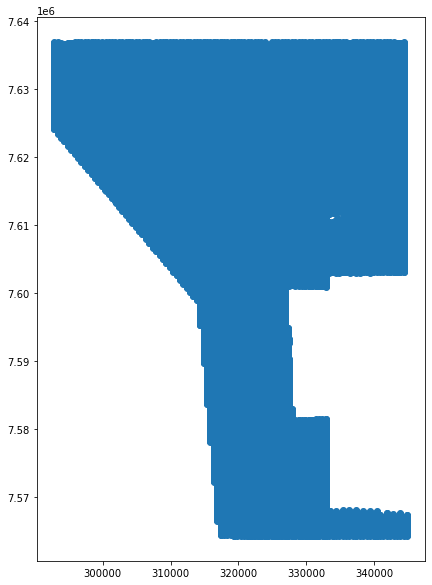

In [24]:
gama.plot(figsize = (10,10))

<AxesSubplot:>

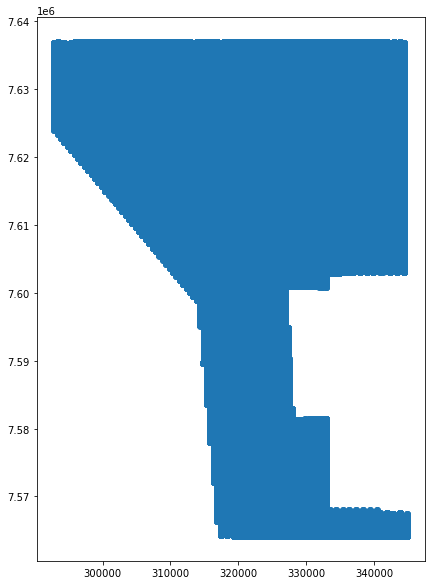

In [25]:
mag_raw.plot(figsize = (10,10))

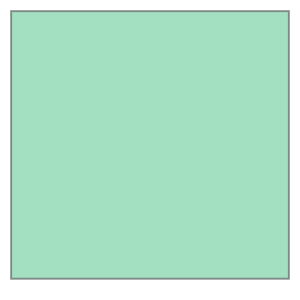

In [26]:
bounds = geometry.Polygon([(329409.535034, 7.628650e+06), (344083.383476, 7.628650e+06), 
                           (344083.383476, 7.614512e+06), (329409.535034, 7.614512e+06)])
area = bounds.area

bounds

In [29]:
cond1 = mag_raw.intersects(bounds)
mag = mag_raw[cond1]
cond2 = gama_raw.intersects(bounds)
gama = gama_raw[cond2]

In [30]:
mag.shape

(55181, 11)

In [31]:
gama.shape

(5511, 13)

In [32]:
mag.to_csv('../database/csv/mag_caconde.csv')
gama.to_csv('../database/csv/gama_caconde.csv')


In [33]:
"""
Create and operate on grids and profiles.

**Grid generation**

* :func:`~fatiando.gridder.regular`
* :func:`~fatiando.gridder.scatter`

**Grid operations**

* :func:`~fatiando.gridder.cut`
* :func:`~fatiando.gridder.profile`

**Interpolation**

* :func:`~fatiando.gridder.interp`
* :func:`~fatiando.gridder.interp_at`
* :func:`~fatiando.gridder.extrapolate_nans`

**Input/Output**

* :func:`~fatiando.gridder.load_surfer`: Read a Surfer grid file and return
  three 1d numpy arrays and the grid shape

**Misc**

* :func:`~fatiando.gridder.spacing`

----

"""

import numpy
import scipy.interpolate
import matplotlib.mlab


def load_surfer(fname, fmt='ascii'):
    """
    Read a Surfer grid file and return three 1d numpy arrays and the grid shape

    Surfer is a contouring, gridding and surface mapping software
    from GoldenSoftware. The names and logos for Surfer and Golden
    Software are registered trademarks of Golden Software, Inc.

    http://www.goldensoftware.com/products/surfer

    According to Surfer structure, x and y are horizontal and vertical
    screen-based coordinates respectively. If the grid is in geographic
    coordinates, x will be longitude and y latitude. If the coordinates
    are cartesian, x will be the easting and y the norting coordinates.

    WARNING: This is opposite to the convention used for Fatiando.
    See io_surfer.py in cookbook.

    Parameters:

    * fname : str
        Name of the Surfer grid file
    * fmt : str
        File type, can be 'ascii' or 'binary'

    Returns:

    * x : 1d-array
        Value of the horizontal coordinate of each grid point.
    * y : 1d-array
        Value of the vertical coordinate of each grid point.
    * grd : 1d-array
        Values of the field in each grid point. Field can be for example
        topography, gravity anomaly etc
    * shape : tuple = (ny, nx)
        The number of points in the vertical and horizontal grid dimensions,
        respectively

    """
    assert fmt in ['ascii', 'binary'], "Invalid grid format '%s'. Should be \
        'ascii' or 'binary'." % (fmt)
    if fmt == 'ascii':
        # Surfer ASCII grid structure
        # DSAA            Surfer ASCII GRD ID
        # nCols nRows     number of columns and rows
        # xMin xMax       X min max
        # yMin yMax       Y min max
        # zMin zMax       Z min max
        # z11 z21 z31 ... List of Z values
        with open(fname) as ftext:
            # DSAA is a Surfer ASCII GRD ID
            id = ftext.readline()
            # Read the number of columns (nx) and rows (ny)
            nx, ny = [int(s) for s in ftext.readline().split()]
            # Read the min/max value of x (columns/longitue)
            xmin, xmax = [float(s) for s in ftext.readline().split()]
            # Read the min/max value of  y(rows/latitude)
            ymin, ymax = [float(s) for s in ftext.readline().split()]
            # Read the min/max value of grd
            zmin, zmax = [float(s) for s in ftext.readline().split()]
            data = numpy.fromiter((float(i) for line in ftext for i in
                                   line.split()), dtype='f')
            grd = numpy.ma.masked_greater_equal(data, 1.70141e+38)
        # Create x and y numpy arrays
        x = numpy.linspace(xmin, xmax, nx)
        y = numpy.linspace(ymin, ymax, ny)
        x, y = [tmp.ravel() for tmp in numpy.meshgrid(x, y)]
    if fmt == 'binary':
        raise NotImplementedError(
            "Binary file support is not implemented yet.")
    return x, y, grd, (ny, nx)

def regular(area, shape, z=None):
    """
    Create a regular grid. Order of the output grid is x varies first, then y.

    Parameters:

    * area
        ``(x1, x2, y1, y2)``: Borders of the grid
    * shape
        Shape of the regular grid, ie ``(ny, nx)``.
    * z
        Optional. z coordinate of the grid points. If given, will return an
        array with the value *z*.

    Returns:

    * ``[xcoords, ycoords]``
        Numpy arrays with the x and y coordinates of the grid points
    * ``[xcoords, ycoords, zcoords]``
        If *z* given. Numpy arrays with the x, y, and z coordinates of the grid
        points

    """
    ny, nx = shape
    x1, x2, y1, y2 = area
    dy, dx = spacing(area, shape)
    x_range = numpy.arange(x1, x2, dx)
    y_range = numpy.arange(y1, y2, dy)
    # Need to make sure that the number of points in the grid is correct
    # because of rounding errors in arange. Sometimes x2 and y2 are included,
    # sometimes not
    if len(x_range) < nx:
        x_range = numpy.append(x_range, x2)
    if len(y_range) < ny:
        y_range = numpy.append(y_range, y2)
    assert len(x_range) == nx, "Failed! x_range doesn't have nx points"
    assert len(y_range) == ny, "Failed! y_range doesn't have ny points"
    xcoords, ycoords = [mat.ravel()
                        for mat in numpy.meshgrid(x_range, y_range)]
    if z is not None:
        zcoords = z * numpy.ones_like(xcoords)
        return [xcoords, ycoords, zcoords]
    else:
        return [xcoords, ycoords]

def scatter(area, n, z=None, seed=None):
    """
    Create an irregular grid with a random scattering of points.

    Parameters:

    * area
        ``(x1, x2, y1, y2)``: Borders of the grid
    * n
        Number of points
    * z
        Optional. z coordinate of the points. If given, will return an
        array with the value *z*.
    * seed : None or int
        Seed used to generate the pseudo-random numbers. If `None`, will use a
        different seed every time. Use the same seed to generate the same
        random points.

    Returns:

    * ``[xcoords, ycoords]``
        Numpy arrays with the x and y coordinates of the points
    * ``[xcoords, ycoords, zcoords]``
        If *z* given. Arrays with the x, y, and z coordinates of the points

    """
    x1, x2, y1, y2 = area
    numpy.random.seed(seed)
    xcoords = numpy.random.uniform(x1, x2, n)
    ycoords = numpy.random.uniform(y1, y2, n)
    numpy.random.seed()
    if z is not None:
        zcoords = z * numpy.ones(n)
        return [xcoords, ycoords, zcoords]
    else:
        return [xcoords, ycoords]

def spacing(area, shape):
    """
    Returns the spacing between grid nodes

    Parameters:

    * area
        ``(x1, x2, y1, y2)``: Borders of the grid
    * shape
        Shape of the regular grid, ie ``(ny, nx)``.

    Returns:

    * ``[dy, dx]``
        Spacing the y and x directions

    """
    x1, x2, y1, y2 = area
    ny, nx = shape
    dx = float(x2 - x1) / float(nx - 1)
    dy = float(y2 - y1) / float(ny - 1)
    return [dy, dx]

def interp(x, y, v, shape, area=None, algorithm='cubic', extrapolate=False):
    """
    Interpolate data onto a regular grid.

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.
    * shape : tuple = (ny, nx)
        Shape of the interpolated regular grid, ie (ny, nx).
    * area : tuple = (x1, x2, y1, y2)
        The are where the data will be interpolated. If None, then will get the
        area from *x* and *y*.
    * algorithm : string
        Interpolation algorithm. Either ``'cubic'``, ``'nearest'``,
        ``'linear'`` (see scipy.interpolate.griddata), or ``'nn'`` for nearest
        neighbors (using matplotlib.mlab.griddata)
    * extrapolate : True or False
        If True, will extrapolate values outside of the convex hull of the data
        points.

    Returns:

    * ``[x, y, v]``
        Three 1D arrays with the interpolated x, y, and v

    """
    if algorithm not in ['cubic', 'linear', 'nearest', 'nn']:
        raise ValueError("Invalid interpolation algorithm: " + str(algorithm))
    ny, nx = shape
    if area is None:
        area = (x.min(), x.max(), y.min(), y.max())
    x1, x2, y1, y2 = area
    xs = numpy.linspace(x1, x2, nx)
    ys = numpy.linspace(y1, y2, ny)
    xp, yp = [i.ravel() for i in numpy.meshgrid(xs, ys)]
    if algorithm == 'nn':
        grid = matplotlib.mlab.griddata(x, y, v, numpy.reshape(xp, shape),
                                        numpy.reshape(yp, shape),
                                        interp='nn').ravel()
        if extrapolate and numpy.ma.is_masked(grid):
            grid = extrapolate_nans(xp, yp, grid)
    else:
        grid = interp_at(x, y, v, xp, yp, algorithm=algorithm,
                         extrapolate=extrapolate)
    return [xp, yp, grid]


def interp_at(x, y, v, xp, yp, algorithm='cubic', extrapolate=False):
    """
    Interpolate data onto the specified points.

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.
    * xp, yp : 1D arrays
        Points where the data values will be interpolated
    * algorithm : string
        Interpolation algorithm. Either ``'cubic'``, ``'nearest'``,
        ``'linear'`` (see scipy.interpolate.griddata)
    * extrapolate : True or False
        If True, will extrapolate values outside of the convex hull of the data
        points.

    Returns:

    * v : 1D array
        1D array with the interpolated v values.

    """
    if algorithm not in ['cubic', 'linear', 'nearest']:
        raise ValueError("Invalid interpolation algorithm: " + str(algorithm))
    grid = scipy.interpolate.griddata((x, y), v, (xp, yp),
                                      method=algorithm).ravel()
    if extrapolate and algorithm != 'nearest' and numpy.any(numpy.isnan(grid)):
        grid = extrapolate_nans(xp, yp, grid)
    return grid

def profile(x, y, v, point1, point2, size, extrapolate=False):
    """
    Extract a data profile between 2 points.

    Uses interpolation to calculate the data values at the profile points.

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.
    * point1, point2 : lists = [x, y]
        Lists the x, y coordinates of the 2 points between which the profile
        will be extracted.
    * size : int
        Number of points along the profile.
    * extrapolate : True or False
        If True, will extrapolate values outside of the convex hull of the data
        points.

    Returns:

    * [xp, yp, distances, vp] : 1d arrays
        ``xp`` and ``yp`` are the x, y coordinates of the points along the
        profile.
        ``distances`` are the distances of the profile points to ``point1``
        ``vp`` are the data points along the profile.

    """
    x1, y1 = point1
    x2, y2 = point2
    maxdist = numpy.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    distances = numpy.linspace(0, maxdist, size)
    angle = numpy.arctan2(y2 - y1, x2 - x1)
    xp = x1 + distances * numpy.cos(angle)
    yp = y1 + distances * numpy.sin(angle)
    vp = interp_at(x, y, v, xp, yp, algorithm='cubic', extrapolate=extrapolate)
    return xp, yp, distances, vp


def extrapolate_nans(x, y, v):
    """"
    Extrapolate the NaNs or masked values in a grid INPLACE using nearest
    value.

    .. warning:: Replaces the NaN or masked values of the original array!

    Parameters:

    * x, y : 1D arrays
        Arrays with the x and y coordinates of the data points.
    * v : 1D array
        Array with the scalar value assigned to the data points.

    Returns:

    * v : 1D array
        The array with NaNs or masked values extrapolated.

    """
    if numpy.ma.is_masked(v):
        nans = v.mask
    else:
        nans = numpy.isnan(v)
    notnans = numpy.logical_not(nans)
    v[nans] = scipy.interpolate.griddata((x[notnans], y[notnans]), v[notnans],
                                         (x[nans], y[nans]),
                                         method='nearest').ravel()
    return v


def cut(x, y, scalars, area):
    """
    Return a subsection of a grid.

    The returned subsection is not a copy! In technical terms, returns a slice
    of the numpy arrays. So changes made to the subsection reflect on the
    original grid. Use numpy.copy to make copies of the subsections and avoid
    this.

    Parameters:

    * x, y
        Arrays with the x and y coordinates of the data points.
    * scalars
        List of arrays with the scalar values assigned to the grid points.
    * area
        ``(x1, x2, y1, y2)``: Borders of the subsection

    Returns:

    * ``[subx, suby, subscalars]``
        Arrays with x and y coordinates and scalar values of the subsection.

    """
    xmin, xmax, ymin, ymax = area
    if len(x) != len(y):
        raise ValueError("x and y must have the same length")
    inside = [i for i in xrange(len(x))
              if x[i] >= xmin and x[i] <= xmax
              and y[i] >= ymin and y[i] <= ymax]
    return [x[inside], y[inside], [s[inside] for s in scalars]]

In [34]:
xu, yu = regular(shape = (1500, 400),
                     area = (292276.074134, 345032.438156,
                             7.564166e+06,  7.636970e+06))

In [35]:
sx, sy = spacing(shape = (1500, 300),
                     area = (292276.074134, 345032.438156,
                             7.564166e+06,  7.636970e+06))

In [36]:
print(sx, sy)

48.56837891927952 176.4426890367893


<AxesSubplot:>

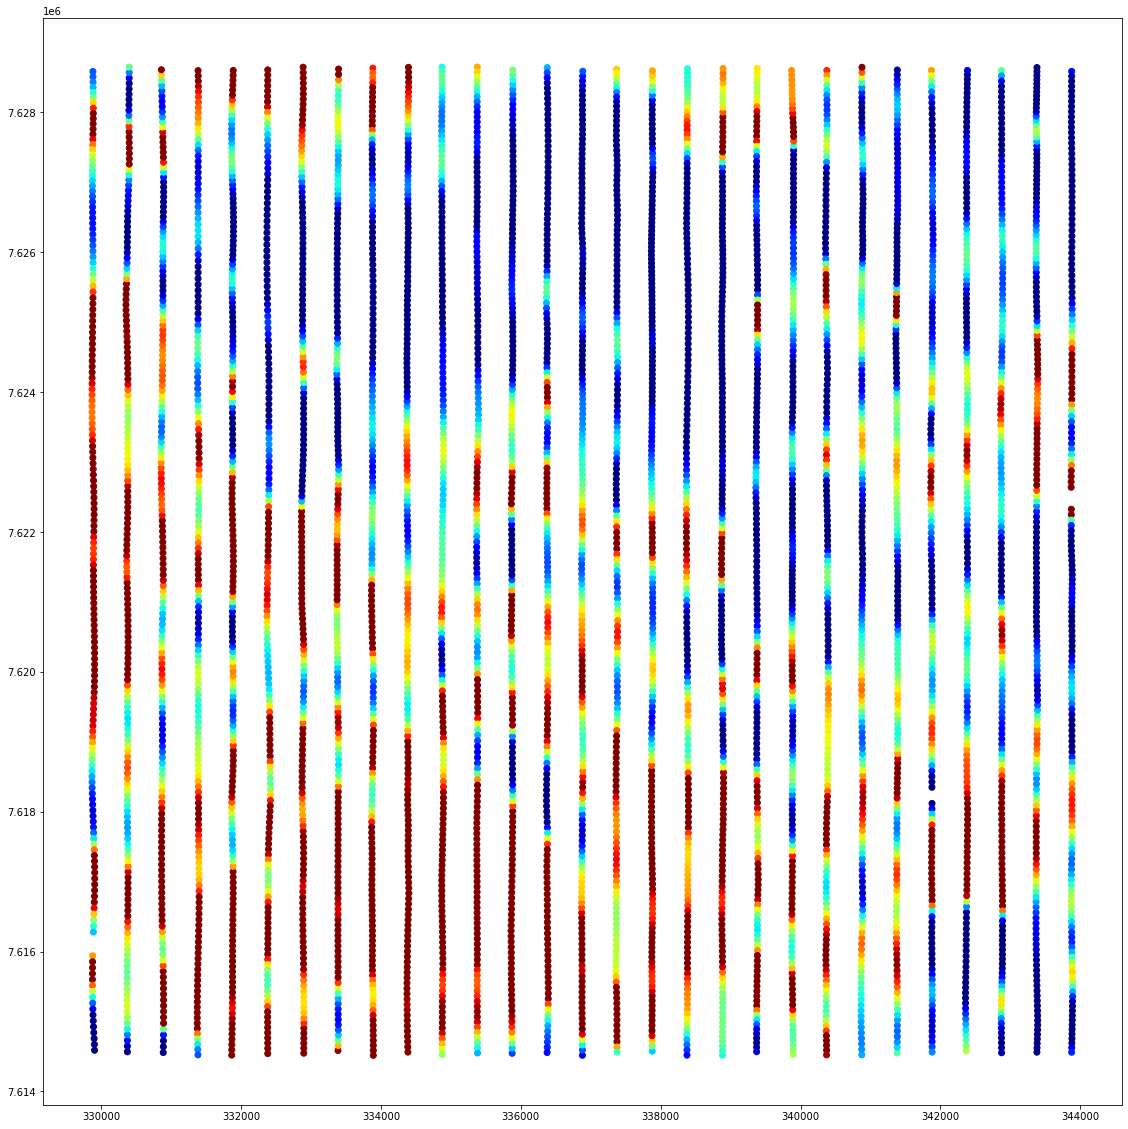

In [41]:
gama.plot(figsize = (20, 20), column = 'THKRAZAO', cmap = 'jet', vmin = np.percentile(gama.THKRAZAO,20),
          vmax = np.percentile(gama.THKRAZAO,80))

<AxesSubplot:>

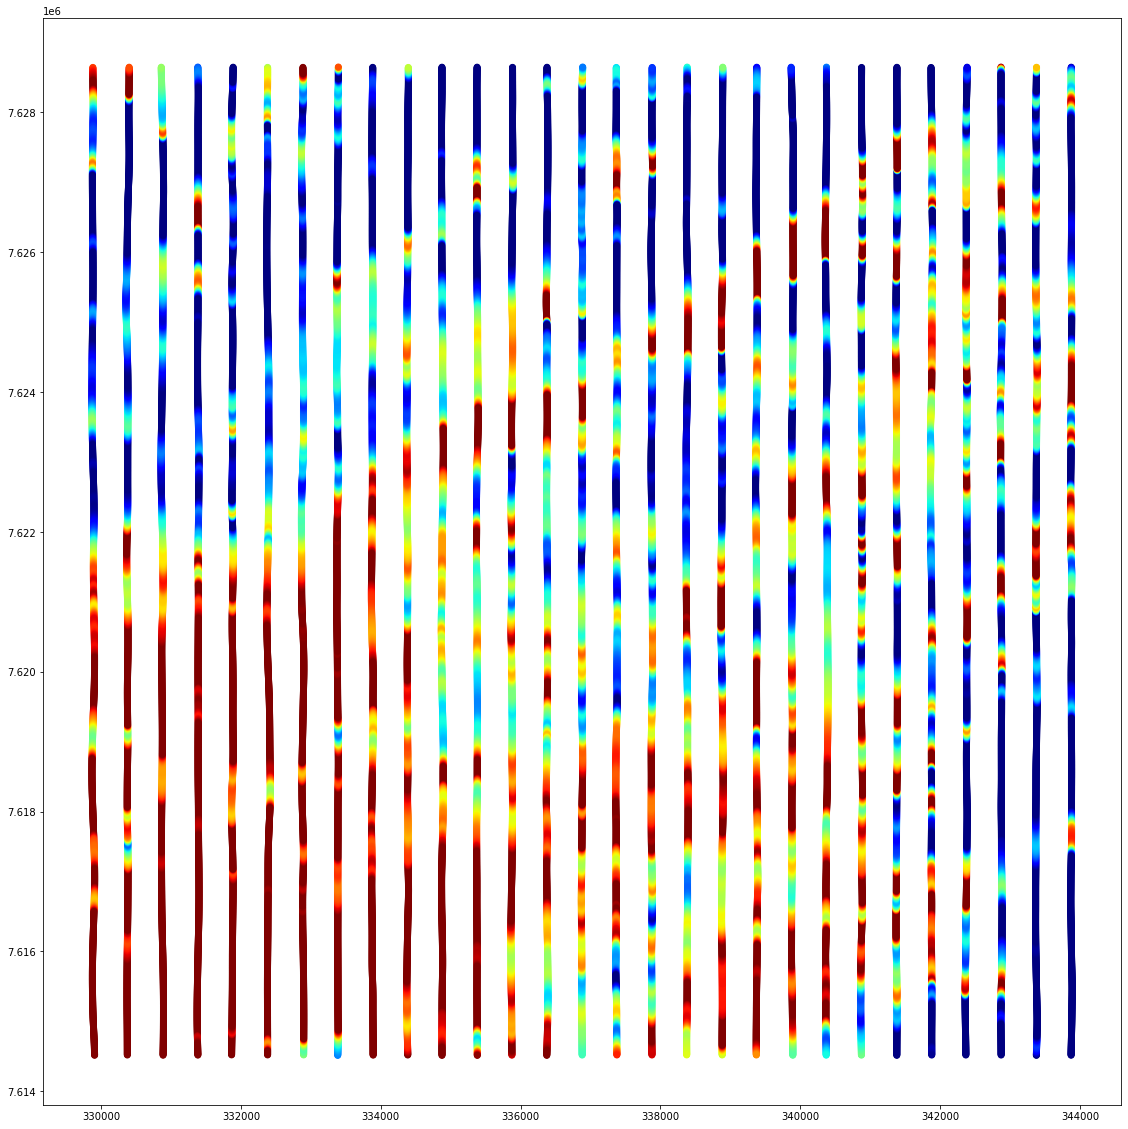

In [40]:
mag.plot(figsize = (20, 20), column = 'MAGIGRF', cmap = 'jet', vmin = np.percentile(mag.MAGIGRF,20),
         vmax = np.percentile(mag.MAGIGRF,80))

<AxesSubplot:>

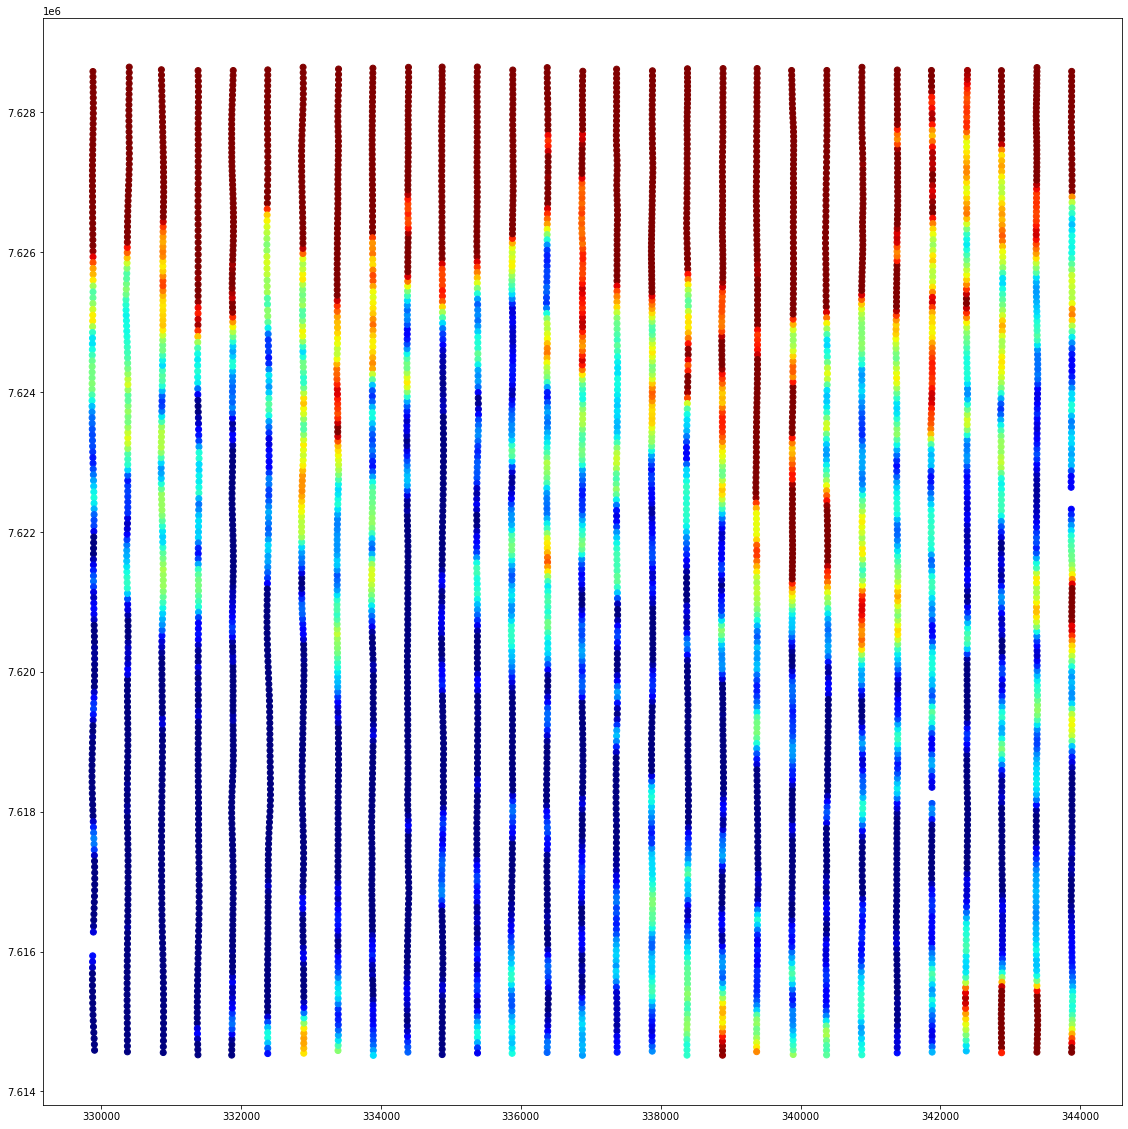

In [42]:
gama.plot(figsize = (20, 20), column = 'MDT', cmap = 'jet', vmin = np.percentile(gama.MDT,20),
          vmax = np.percentile(gama.MDT,80))